$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw4/answers.py`.

In [2]:
import cs3600.plot as plot
import cs3600.download
from hw4.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs3600.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File C:\Users\alon2\.pytorch-datasets\lfw-bush.zip exists, skipping download.
Extracting C:\Users\alon2\.pytorch-datasets\lfw-bush.zip...
Extracted 531 to C:\Users\alon2\.pytorch-datasets\lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


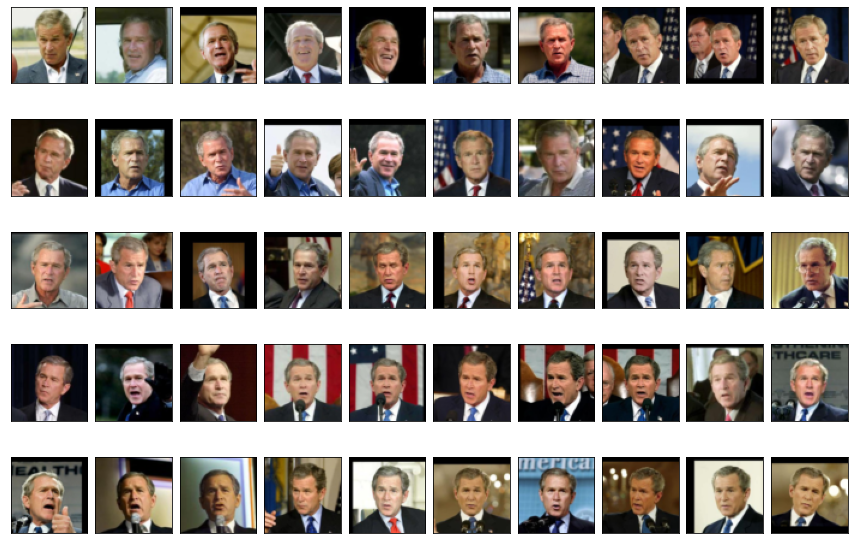

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw4/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [14]:
import hw4.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): EncoderCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(64, eps=1e-06, momentum=0.9, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout2d(p=0.3, inplace=False)
      (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (6): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (7): BatchNorm2d(128, eps=1e-06, momentum=0.9, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Dropout2d(p=0.3, inplace=False)
      (10): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (11): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (12): BatchNorm2d(256, eps=1e-06, momentum=0.9, affine=True, track_running_stats=True)
      (13): ReLU()
      (14): Dropout2d(p=0.3, in

**TODO**: Implement the `Generator` class in the `hw4/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [39]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (in_layer): Linear(in_features=128, out_features=8192, bias=False)
  (cnn): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(512, eps=1e-06, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-06, momentum=0.9, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-06, momentum=0.9, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-06, momentum=0.9, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(5, 5), stride=(2

### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw4/gan.py` module.

In [40]:
from hw4.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw4/gan.py` module.

In [41]:
from hw4.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw4/gan.py` module.

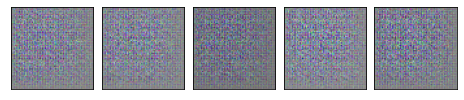

In [42]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw4/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw4/answers.py` module.

In [43]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw4.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 8, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0005}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0005}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw4.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:53<00:00,  1.25it/s]
Discriminator loss: 1.2268816998867846
Generator loss:     15.144260652029692
Saved checkpoint.


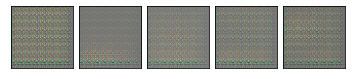

--- EPOCH 2/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:55<00:00,  1.22it/s]
Discriminator loss: 3.794240161998948
Generator loss:     28.849774641777152
Saved checkpoint.


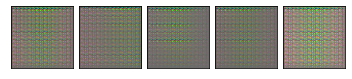

--- EPOCH 3/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.19it/s]
Discriminator loss: 1.7016064849362444
Generator loss:     37.21929244141081
Saved checkpoint.


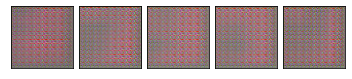

--- EPOCH 4/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 1.5856322101247844
Generator loss:     36.11811538240803
Saved checkpoint.


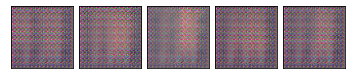

--- EPOCH 5/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 1.0265367890694248
Generator loss:     25.96412850137967
Saved checkpoint.


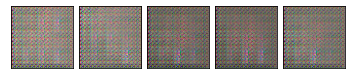

--- EPOCH 6/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 0.7918714278224689
Generator loss:     17.776936780160934
Saved checkpoint.


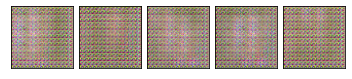

--- EPOCH 7/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 0.7988390079629955
Generator loss:     16.37229913740016
Saved checkpoint.


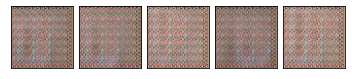

--- EPOCH 8/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 0.41414331333405935
Generator loss:     16.050871393573818
Saved checkpoint.


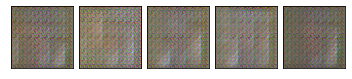

--- EPOCH 9/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.12it/s]
Discriminator loss: 0.8603573334750845
Generator loss:     18.28213075737455
Saved checkpoint.


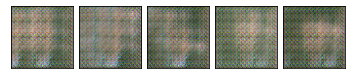

--- EPOCH 10/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 1.0058664561652426
Generator loss:     13.513566280478862
Saved checkpoint.


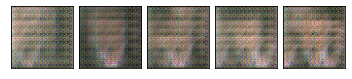

--- EPOCH 11/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 0.9169262735478914
Generator loss:     10.17104290492499
Saved checkpoint.


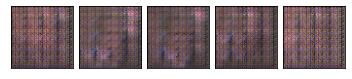

--- EPOCH 12/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.10it/s]
Discriminator loss: 0.9993757717867395
Generator loss:     10.237022513773903
Saved checkpoint.


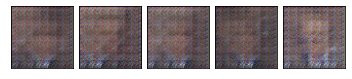

--- EPOCH 13/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 0.9710293149214182
Generator loss:     10.664409157055527
Saved checkpoint.


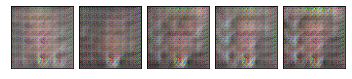

--- EPOCH 14/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 0.48332576820654655
Generator loss:     9.672872201720281
Saved checkpoint.


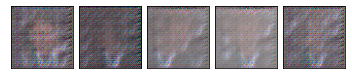

--- EPOCH 15/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 0.5140009223302798
Generator loss:     12.444083107051565
Saved checkpoint.


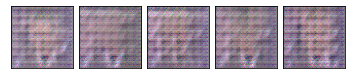

--- EPOCH 16/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 0.6426116644001719
Generator loss:     12.27963952875849
Saved checkpoint.


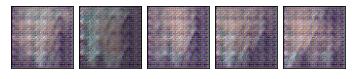

--- EPOCH 17/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 1.1819046773572466
Generator loss:     16.685657291270015
Saved checkpoint.


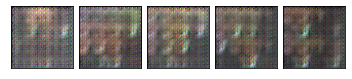

--- EPOCH 18/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.12it/s]
Discriminator loss: 0.7439158436522555
Generator loss:     13.98024259752302
Saved checkpoint.


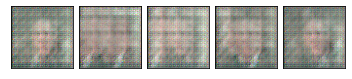

--- EPOCH 19/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.12it/s]
Discriminator loss: 0.7568419922643633
Generator loss:     13.512041013632247
Saved checkpoint.


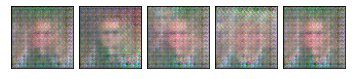

--- EPOCH 20/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.14it/s]
Discriminator loss: 1.0998986951673209
Generator loss:     20.081222975431984
Saved checkpoint.


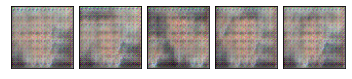

--- EPOCH 21/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 0.4956964414511154
Generator loss:     24.25279578877919
Saved checkpoint.


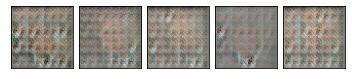

--- EPOCH 22/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 1.117839189830111
Generator loss:     20.390571380729106
Saved checkpoint.


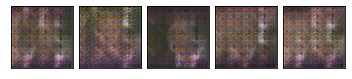

--- EPOCH 23/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.12it/s]
Discriminator loss: 0.7620747981231604
Generator loss:     22.50487311206647
Saved checkpoint.


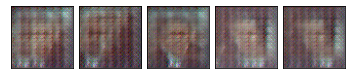

--- EPOCH 24/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.12it/s]
Discriminator loss: 1.5337413080147844
Generator loss:     22.04763630254945
Saved checkpoint.


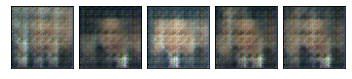

--- EPOCH 25/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.12it/s]
Discriminator loss: 0.9516113324841456
Generator loss:     21.021925506307117
Saved checkpoint.


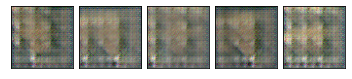

--- EPOCH 26/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.12it/s]
Discriminator loss: 0.6372483539492336
Generator loss:     21.01510882021776
Saved checkpoint.


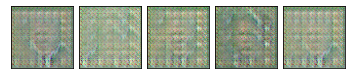

--- EPOCH 27/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 1.2752231008081294
Generator loss:     32.18882685276999
Saved checkpoint.


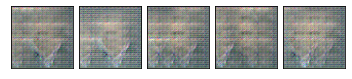

--- EPOCH 28/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.12it/s]
Discriminator loss: 1.647467217338619
Generator loss:     27.627948519009262
Saved checkpoint.


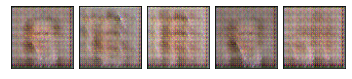

--- EPOCH 29/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 1.230816777295141
Generator loss:     34.90733391491335
Saved checkpoint.


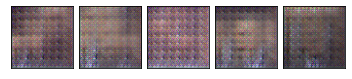

--- EPOCH 30/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.09it/s]
Discriminator loss: 1.7593098794346425
Generator loss:     30.50067998402154
Saved checkpoint.


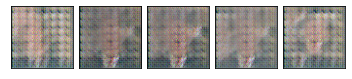

--- EPOCH 31/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:08<00:00,  1.03s/it]
Discriminator loss: 1.275212677557077
Generator loss:     26.606952183282196
Saved checkpoint.


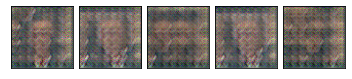

--- EPOCH 32/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:06<00:00,  1.00it/s]
Discriminator loss: 1.8904176358856373
Generator loss:     23.899212563215798
Saved checkpoint.


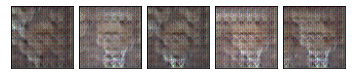

--- EPOCH 33/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:07<00:00,  1.01s/it]
Discriminator loss: 1.8795065470595858
Generator loss:     24.752870890631606
Saved checkpoint.


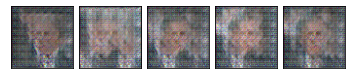

--- EPOCH 34/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]
Discriminator loss: 1.497085686495055
Generator loss:     24.90392666432395
Saved checkpoint.


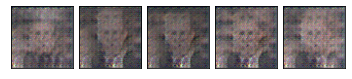

--- EPOCH 35/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 1.602765690702111
Generator loss:     23.675039277147892
Saved checkpoint.


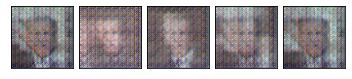

--- EPOCH 36/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]
Discriminator loss: 1.8891741081849853
Generator loss:     25.105912265492908
Saved checkpoint.


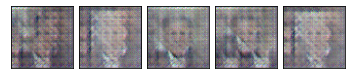

--- EPOCH 37/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 1.3407002421679781
Generator loss:     22.47113649880708
Saved checkpoint.


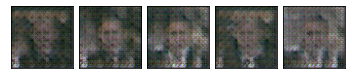

--- EPOCH 38/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 1.5759933773261399
Generator loss:     22.1504420166585
Saved checkpoint.


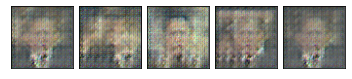

--- EPOCH 39/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]
Discriminator loss: 1.627005275950503
Generator loss:     21.05289974853174
Saved checkpoint.


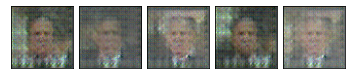

--- EPOCH 40/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 1.5187022065493598
Generator loss:     19.86717335857562
Saved checkpoint.


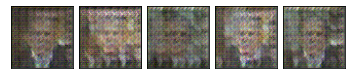

--- EPOCH 41/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]
Discriminator loss: 1.390652589611153
Generator loss:     19.49935342304742
Saved checkpoint.


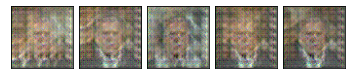

--- EPOCH 42/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.10it/s]
Discriminator loss: 1.2948501971897795
Generator loss:     16.475938789880097
Saved checkpoint.


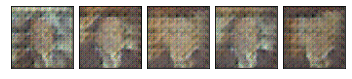

--- EPOCH 43/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 1.1598722716765617
Generator loss:     17.22450187313023
Saved checkpoint.


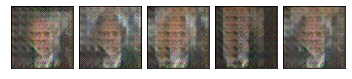

--- EPOCH 44/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 1.431052735047554
Generator loss:     22.186060343215715
Saved checkpoint.


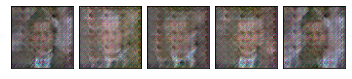

--- EPOCH 45/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 1.0419652066124019
Generator loss:     21.1294261946607
Saved checkpoint.


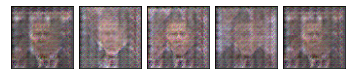

--- EPOCH 46/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 1.8252674445732315
Generator loss:     22.05213094113478
Saved checkpoint.


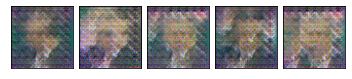

--- EPOCH 47/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]
Discriminator loss: 1.2979941779553001
Generator loss:     24.617665191194906
Saved checkpoint.


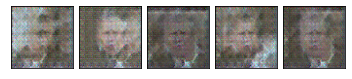

--- EPOCH 48/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 1.709528149953529
Generator loss:     18.705808212508018
Saved checkpoint.


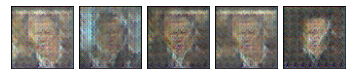

--- EPOCH 49/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]
Discriminator loss: 1.038116571173739
Generator loss:     14.859017874906534
Saved checkpoint.


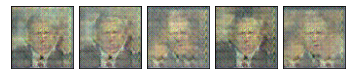

--- EPOCH 50/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 1.4701612247015112
Generator loss:     15.388712014724959
Saved checkpoint.


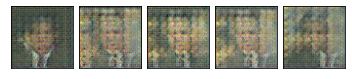

--- EPOCH 51/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.08it/s]
Discriminator loss: 1.4392789166365096
Generator loss:     18.682729130360617
Saved checkpoint.


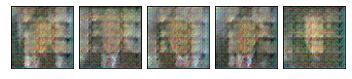

--- EPOCH 52/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]
Discriminator loss: 1.6174385452003621
Generator loss:     19.966100009519664
Saved checkpoint.


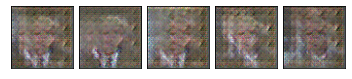

--- EPOCH 53/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]
Discriminator loss: 1.5374872800129562
Generator loss:     18.470845357695623
Saved checkpoint.


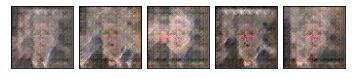

--- EPOCH 54/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.09it/s]
Discriminator loss: 2.027187508211207
Generator loss:     19.407400745064464
Saved checkpoint.


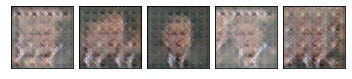

--- EPOCH 55/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.09it/s]
Discriminator loss: 1.1239279637585824
Generator loss:     18.91304685108697
Saved checkpoint.


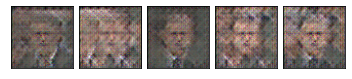

--- EPOCH 56/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]
Discriminator loss: 1.061575874185829
Generator loss:     18.661741384819372
Saved checkpoint.


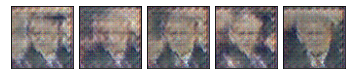

--- EPOCH 57/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.09it/s]
Discriminator loss: 1.6242860984891208
Generator loss:     18.29345841905964
Saved checkpoint.


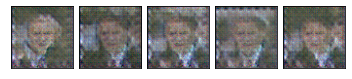

--- EPOCH 58/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.10it/s]
Discriminator loss: 1.0436008912858679
Generator loss:     18.89708111891106
Saved checkpoint.


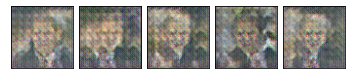

--- EPOCH 59/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]
Discriminator loss: 1.2604859978405398
Generator loss:     22.60695083105742
Saved checkpoint.


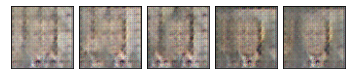

--- EPOCH 60/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:14<00:00,  1.11s/it]
Discriminator loss: 0.9543244131465456
Generator loss:     34.77746285965193
Saved checkpoint.


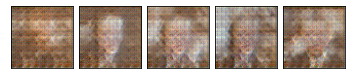

--- EPOCH 61/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:09<00:00,  1.04s/it]
Discriminator loss: 1.3493972167150299
Generator loss:     25.80584518945039
Saved checkpoint.


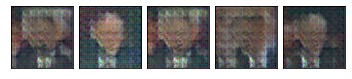

--- EPOCH 62/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:05<00:00,  1.02it/s]
Discriminator loss: 1.536085640983795
Generator loss:     29.807323612383943
Saved checkpoint.


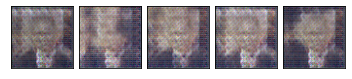

--- EPOCH 63/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:06<00:00,  1.01it/s]
Discriminator loss: 2.0917100466009395
Generator loss:     26.101818429889963
Saved checkpoint.


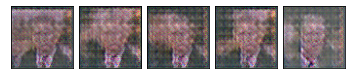

--- EPOCH 64/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.09it/s]
Discriminator loss: 1.8405512524629706
Generator loss:     28.112073706157172
Saved checkpoint.


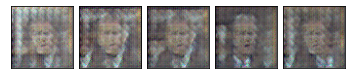

--- EPOCH 65/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 1.2908820867983264
Generator loss:     22.665075814546043
Saved checkpoint.


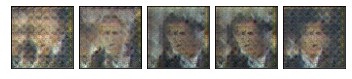

--- EPOCH 66/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]
Discriminator loss: 2.190953945268446
Generator loss:     21.7746853614921
Saved checkpoint.


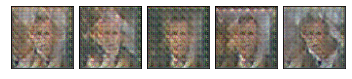

--- EPOCH 67/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 1.6643167002432382
Generator loss:     20.204679240041703
Saved checkpoint.


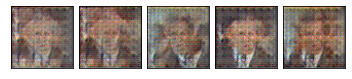

--- EPOCH 68/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.09it/s]
Discriminator loss: 1.7363532830530137
Generator loss:     22.453463008154685
Saved checkpoint.


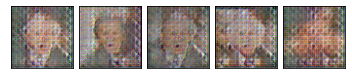

--- EPOCH 69/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 1.5617036107760758
Generator loss:     22.174346838424455
Saved checkpoint.


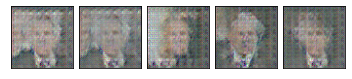

--- EPOCH 70/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.09it/s]
Discriminator loss: 2.05635132384834
Generator loss:     22.63282400814455
Saved checkpoint.


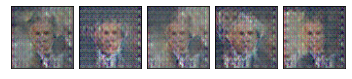

--- EPOCH 71/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]
Discriminator loss: 1.5390994922438663
Generator loss:     20.107977596681508
Saved checkpoint.


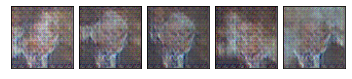

--- EPOCH 72/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]
Discriminator loss: 1.2908064396078907
Generator loss:     19.87435342304742
Saved checkpoint.


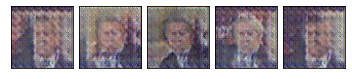

--- EPOCH 73/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]
Discriminator loss: 1.6997496805973906
Generator loss:     19.548063785282533
Saved checkpoint.


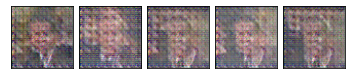

--- EPOCH 74/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.10it/s]
Discriminator loss: 1.3453244620294713
Generator loss:     20.918892945816268
Saved checkpoint.


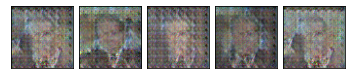

--- EPOCH 75/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]
Discriminator loss: 1.473145220261901
Generator loss:     20.62782155933665
Saved checkpoint.


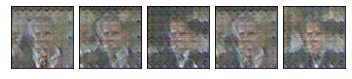

--- EPOCH 76/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.09it/s]
Discriminator loss: 1.261013121302448
Generator loss:     21.458541329227277
Saved checkpoint.


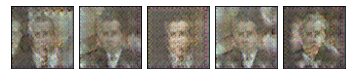

--- EPOCH 77/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:04<00:00,  1.04it/s]
Discriminator loss: 1.636193094413672
Generator loss:     21.11007947352395
Saved checkpoint.


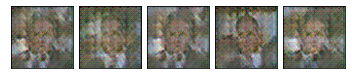

--- EPOCH 78/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:06<00:00,  1.01it/s]
Discriminator loss: 2.208192108727213
Generator loss:     23.071413068629024
Saved checkpoint.


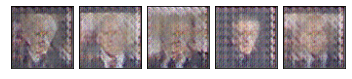

--- EPOCH 79/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:04<00:00,  1.04it/s]
Discriminator loss: 1.5021663523876845
Generator loss:     21.460957171312018
Saved checkpoint.


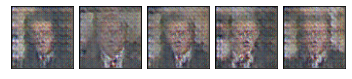

--- EPOCH 80/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:09<00:00,  1.04s/it]
Discriminator loss: 1.105241634285272
Generator loss:     23.067400960779903
Saved checkpoint.


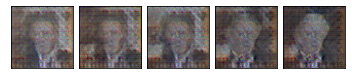

--- EPOCH 81/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:10<00:00,  1.05s/it]
Discriminator loss: 1.7185375481399137
Generator loss:     21.065938906883126
Saved checkpoint.


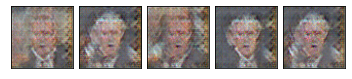

--- EPOCH 82/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:04<00:00,  1.04it/s]
Discriminator loss: 1.5571250177141447
Generator loss:     18.449940382544675
Saved checkpoint.


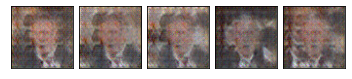

--- EPOCH 83/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:04<00:00,  1.04it/s]
Discriminator loss: 1.5680091783626755
Generator loss:     20.221620815903393
Saved checkpoint.


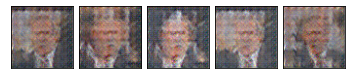

--- EPOCH 84/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]
Discriminator loss: 1.734829379996257
Generator loss:     23.47557255047471
Saved checkpoint.


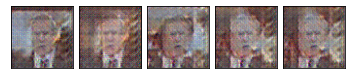

--- EPOCH 85/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:04<00:00,  1.04it/s]
Discriminator loss: 1.2627005543726593
Generator loss:     20.245736762658872
Saved checkpoint.


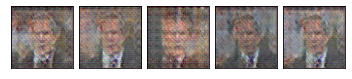

--- EPOCH 86/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]
Discriminator loss: 1.476496049050075
Generator loss:     15.640874096984739
Saved checkpoint.


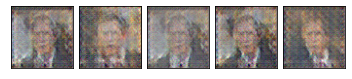

--- EPOCH 87/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:04<00:00,  1.05it/s]
Discriminator loss: 1.7035408273561676
Generator loss:     18.729448354066307
Saved checkpoint.


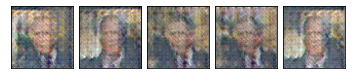

--- EPOCH 88/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:03<00:00,  1.05it/s]
Discriminator loss: 1.5305106302917892
Generator loss:     17.316557533705414
Saved checkpoint.


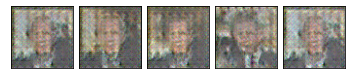

--- EPOCH 89/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 2.1811227800685966
Generator loss:     18.074967654783336
Saved checkpoint.


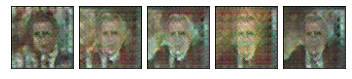

--- EPOCH 90/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:08<00:00,  1.02s/it]
Discriminator loss: 1.6694267923707393
Generator loss:     17.712080571188856
Saved checkpoint.


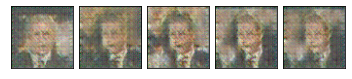

--- EPOCH 91/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:09<00:00,  1.04s/it]
Discriminator loss: 1.7300812050477783
Generator loss:     16.927775909651572
Saved checkpoint.


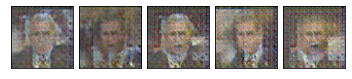

--- EPOCH 92/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 1.3395326317691092
Generator loss:     17.371389759120657
Saved checkpoint.


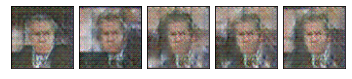

--- EPOCH 93/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:10<00:00,  1.05s/it]
Discriminator loss: 1.693448521975261
Generator loss:     16.08138243831805
Saved checkpoint.


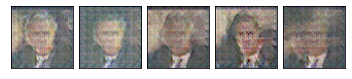

--- EPOCH 94/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:06<00:00,  1.00it/s]
Discriminator loss: 1.2892242067340594
Generator loss:     14.589772665678565
Saved checkpoint.


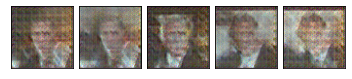

--- EPOCH 95/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]
Discriminator loss: 1.304706603511056
Generator loss:     15.976239997949174
Saved checkpoint.


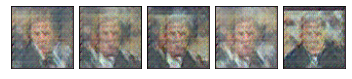

--- EPOCH 96/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:04<00:00,  1.04it/s]
Discriminator loss: 1.6640008854777066
Generator loss:     14.82839669754256
Saved checkpoint.


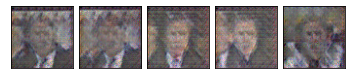

--- EPOCH 97/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]
Discriminator loss: 1.0169660388978559
Generator loss:     17.07953029426176
Saved checkpoint.


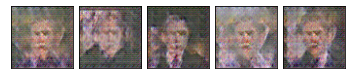

--- EPOCH 98/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]
Discriminator loss: 1.79509153784211
Generator loss:     15.838325963091494
Saved checkpoint.


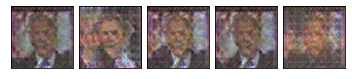

--- EPOCH 99/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:04<00:00,  1.04it/s]
Discriminator loss: 1.4629288384718682
Generator loss:     17.66684330043508
Saved checkpoint.


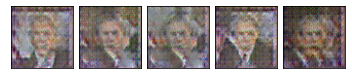

--- EPOCH 100/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:04<00:00,  1.04it/s]
Discriminator loss: 0.9593453514042185
Generator loss:     18.01755323694713
Saved checkpoint.


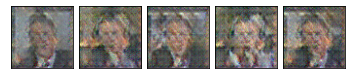

In [44]:
import IPython.display
import tqdm
from hw4.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


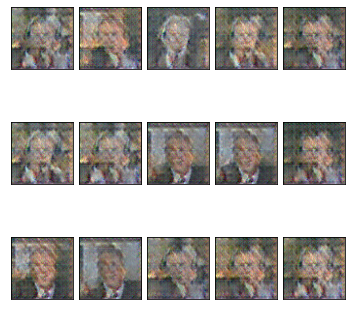

In [45]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw4/answers.py`.

In [46]:
from cs3600.answers import display_answer
import hw4.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [47]:
display_answer(hw4.answers.part3_q1)


**Your answer:**
While training the GAN model, we basically optimizing the loss functions of the generator and the discriminator.
The generator is trained by generating a data point, send it to the discriminator and updating it based on the loss function. In this case, we do maintain gradients because we want to update the weights of the generator during backprop.
The discriminator it trained by getting the data from the generator, classify it, and update the loss function based on the classification. In this case, we don't update the generator wights so we don't maintain the gradients.


### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [48]:
display_answer(hw4.answers.part3_q2)


**Your answer:**
1. No, the GAN performance depends both on the loss value of the generatot and the discriminator. 
Maybe the deiscriminator is easily fooled by the generator, so the generator loss in this case will decrease although it's not generating good data.

2. It means that the generator is still fooling the discriminator, without the econd one identifing it.
In other words, the discriminator is failing on seperating between real data and fake data from the generator.
This means that the model is failing in it's pupose to train. 


### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [49]:
display_answer(hw4.answers.part3_q3)


**Your answer:**
We can see that the GAN produced more realistic and sharper images comparing to the VAE.
The VAE tries to generate images based on the MSE loss comparing the input data and the generated data. This causes the bluriness of the output. It also causes the generated images be similar to each other.
On the pther hand, the GAN's generator is not aware at all to the input data. All it has is the discriminator decision wheter it has done a good job in generating the images on not. By that, well designed generator and discriminator will produce better images.
